# Multi-resolution separation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

import healpy as hp
import pysm3
import pysm3.units as u

from fgbuster import get_instrument, get_sky, get_observation  # Predefined instrumental and sky-creation configurations
import fgbuster.separation_recipes as sr

# Imports needed for component separation
from fgbuster import (CMB, Dust, Synchrotron,  # sky-fitting model
                      MixingMatrix)  # separation routine

From more basic examples you know that `basic_comp_sep` allows you to tile the sky in healpix pixels at a given `nside` and perform the fit of the spectral parameters independently for each tile. However, you potentially want to fit different parameters at different resolutions. You can achieve this with the `multi_res_comp_sep` utility function in `separation_recipes`. Here is an example of how it works.

## Simulate your frequency maps

In [2]:
nside = 8
sky = get_sky(nside, 'c1d0s0')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)
freq_maps = freq_maps[:, 1:]  # Select polarization

## Define what you fit for
Create your sky model as a list of components

In [3]:
components = [CMB(), Dust(353.), Synchrotron(23., running=None, nu_pivot=70.)]

In [4]:
for comp in components:
    comp.defaults = [d*1.05 for d in comp.defaults] 

## Component separation
`multi_res_comp_sep` has almost the same signature of `basic_comp_sep`. The only difference is the `nside` parameter, which becomes `nsides`. It is no longer an integer but a list of integers, each specifying the resolution of a parameters.

In [5]:
nsides = [4, 1, 2, 0]

Which means that

In [6]:
for nside, param in zip(nsides, MixingMatrix(*components).params):
    print(f"{param} is fitted for at nside {nside}")

Dust.beta_d is fitted for at nside 4
Dust.temp is fitted for at nside 1
Synchrotron.beta_pl is fitted for at nside 2
Synchrotron.running is fitted for at nside 0


In [7]:
result = sr.multi_res_comp_sep(components, instrument, freq_maps, nsides=nsides)#, method='L-BFGS-B', options=dict(disp=True))                                                                                                                ))

Note that all the parameters are fitted simultaneously. This makes the maximization of the likelihood substantially more difficult. Consider tuning the parameters of the minimizer [``scipy.optimize.minimize``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

## Explore the results
Unlike `basic_comp_sep`, `res.x` is now a list — since the maps have different resolutions you can not stack them in an `ndarray` — but you access the maps of each parameters in the same way. 

Synchrotron.running 8.709583479302986e-07


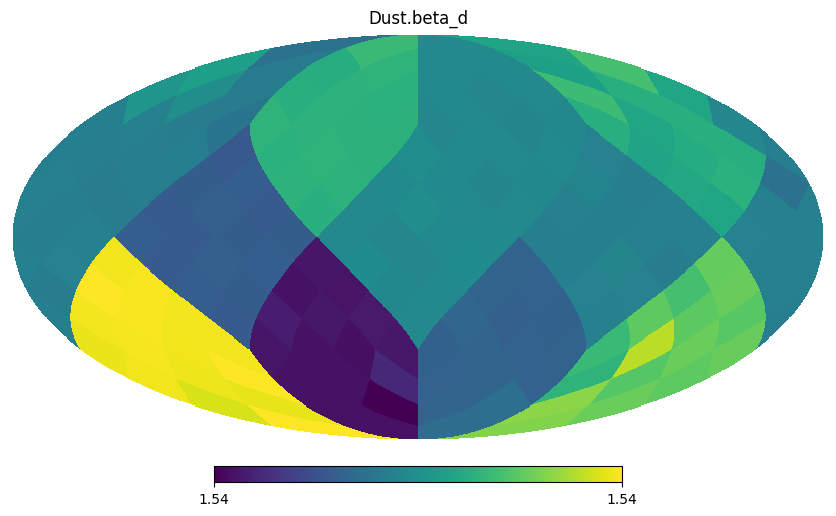

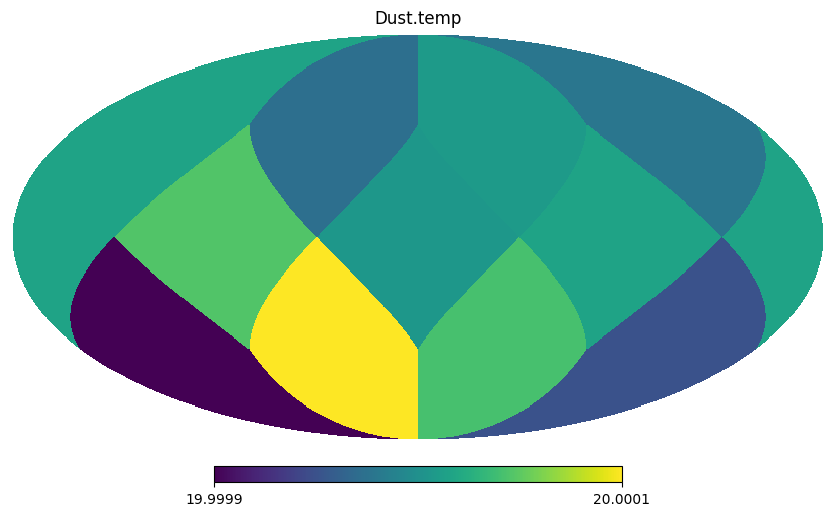

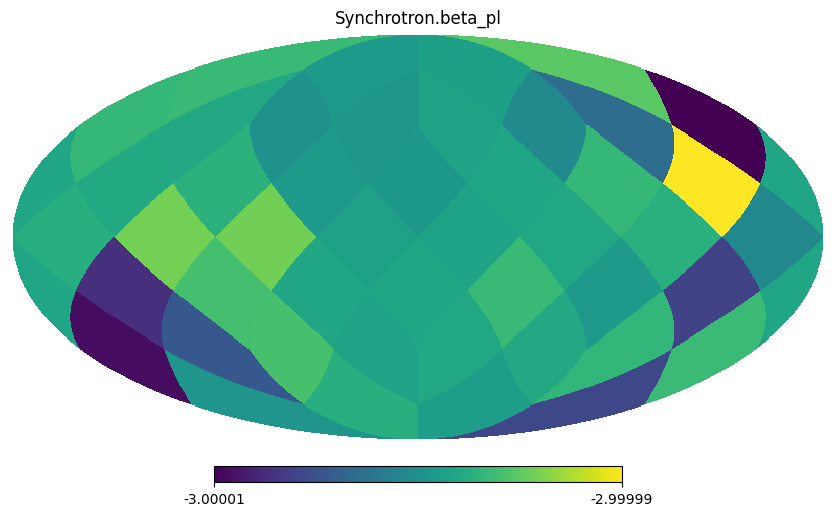

In [8]:
for par_x, par in zip(result.x, result.params):
    if len(par_x)>1:
        hp.mollview(par_x, title=par)
    else:
        print(par, par_x[0])



The amplitudes of the components are stacked in the ``s`` attribute and they are in the same format of the input frequency maps: Q and U healpix maps, in this case.

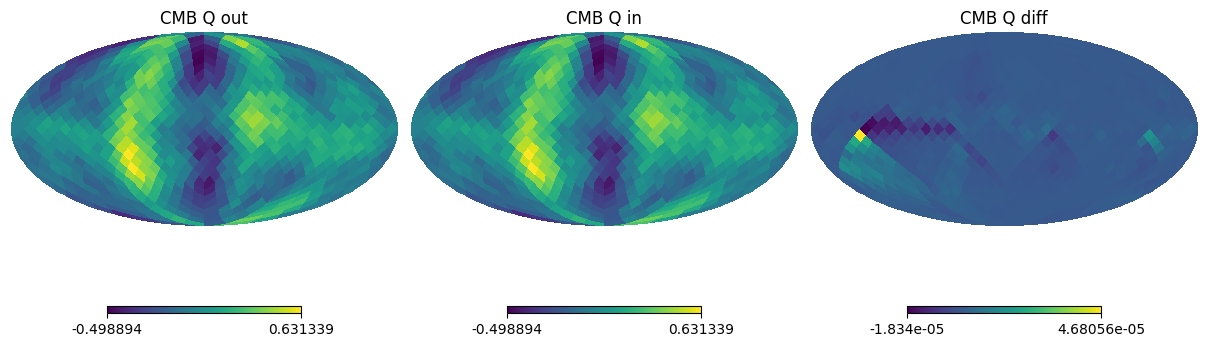

In [9]:
hp.mollview(result.s[0,0], title='CMB Q out', sub=(1, 3, 1))
hp.mollview(sky.components[0].map[1].value, title='CMB Q in', sub=(1, 3, 2))
hp.mollview(result.s[0,0] - sky.components[0].map[1].value, title='CMB Q diff', sub=(1, 3, 3))

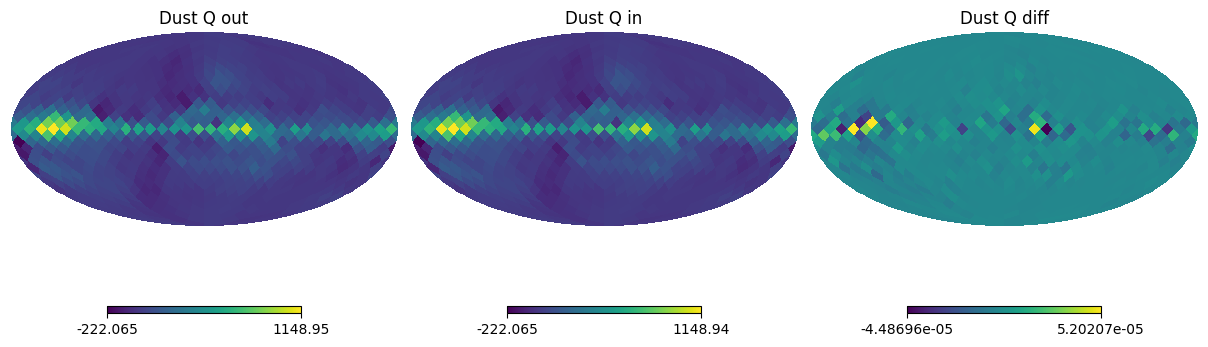

In [10]:
ref = sky.components[1].Q_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky.components[1].freq_ref_P)).value
hp.mollview(result.s[1, 0], title='Dust Q out', sub=(1, 3, 1))
hp.mollview(ref, title='Dust Q in', sub=(1, 3, 2))
hp.mollview(result.s[1, 0] - ref, title='Dust Q diff', sub=(1, 3, 3))

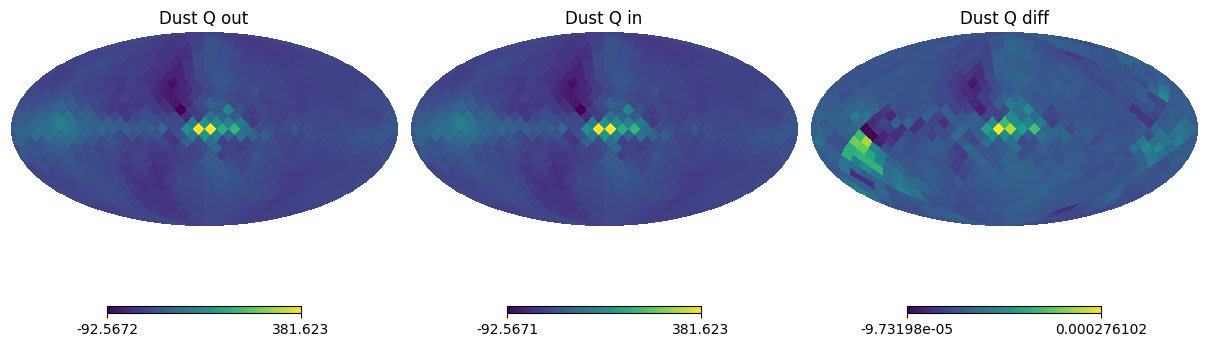

In [11]:
ref = sky.components[2].Q_ref.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(sky.components[2].freq_ref_P)).value
hp.mollview(result.s[2, 0], title='Dust Q out', sub=(1, 3, 1))
hp.mollview(ref, title='Dust Q in', sub=(1, 3, 2))
hp.mollview(result.s[2, 0] - ref, title='Dust Q diff', sub=(1, 3, 3))